**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
- [Approches Bag-of-words](#toc2_)    
  - [TF-IDF](#toc2_1_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc3_)    
- [CountVectorizer](#toc4_)    
- [LDA](#toc5_)    
- [🚧 gensim LDA ?](#toc6_)    
- [🚧 calcul matriciel pour predictions avec LDA](#toc7_)    
- [🚧 NMF](#toc8_)    
- [🚧 vrac utile](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [131]:
# OS & env
import os
import logging

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from Levenshtein import ratio
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

# home made functions from the src folder
from src.scrap_and_clean import words_filter
from src.models import results_from_vec_matrix
from src.models import get_lda_topics

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

### 🚧 Si pas de données pré-traitées, faire pré-traitement au lieu de message "run EDA NB"

In [24]:
if not os.path.exists("data/data_preprocessed.pkl"):
    logging.warning("Missing data: run EDA notebook first")
else:
    with open("data/data_preprocessed.pkl", "rb") as df:
        df = pickle.load(df)

In [25]:
print(f"DF shape: {df.shape}")
display(df.head())

DF shape: (50000, 10)


,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount,title_bow,body_bow,doc_bow
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,"[ios, app-store, plist, appstore-approval, pri...",24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful builds apple,itms-91053 missing api declaration privacy sud...
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,"[python, algorithm, performance, sorting, time...",28,2,2024-03-05 15:21:50,2699,builtin sorted slower list containing descendi...,sorted four similar lists list consistently ta...,builtin sorted slower list containing descendi...
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,"[c++, windows, multithreading, stl, shared-lock]",26,5,2024-03-01 23:09:59,1388,std :shared_mutex :unlock_shared blocks even t...,team encountered deadlock suspect bug windows ...,std :shared_mutex :unlock_shared blocks even t...
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,"[c++, visual-c++, language-lawyer, unique-ptr,...",15,1,2024-02-22 11:29:42,490,rules nullptr init unique_ptr change c++23,compiles msvc c++20 mode failes c++23 mode cur...,rules nullptr init unique_ptr change c++23 com...
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,"[c++, elf, dynamic-linking, abi, relocation]",16,1,2024-02-19 21:42:03,1746,order elf relocations applied specified,consider following two linux system use_messag...,order elf relocations applied specified consid...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Données communes

In [26]:
tags = df["Tags"].apply(lambda x: " ".join(x)).to_list()
titles = df["title_bow"].to_list()
bodies = df["body_bow"].to_list()
corpus = df["doc_bow"].to_list()

Train / test split

In [27]:
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    corpus, tags, test_size=0.2, random_state=random_state
)

# <a id='toc2_'></a>[Approches Bag-of-words](#toc0_)

## Méthode de scoring

On cherche à évaluer l'efficacité d'un modèle qui renvoie deux listes de termes, sans toutefois appliquer de solution binaire comme la présence ou non du terme exact dans les deux listes, au vu de la diversité des termes employés.

Un moyen simple d'utiliser le meilleur ratio de Levenshtein (similarité entre chaînes de caractères) avec un seuil cohérent et de le diviser par le nombre de termes.

> Une similarité de 70% permet par exemple de mettre une similarité de 0 entre 'c' et 'c#', une similarité de 0.71 entre 'spring' et 'spring-boot' mais de 0 entre 'spring-boot' et 'boot'.



- le score maximum de 1 équivaut à tous les termes exacts trouvés,
- le minimum de 0 signifie qu'il n'y a pas eu de terme suffisamment proche pour passer le seuil défini

In [138]:
def score_terms(pred_words, target_words, cutoff=0.7) -> float:
    """Return a score of terms similarity between 2 lists of strings"""
    score = 0
    for p_w in pred_words:
        score += max(ratio(t, p_w, score_cutoff=cutoff) for t in target_words)
    score = np.round(score / len(pred_words), 3)
    
    return score

## <a id='toc2_1_'></a>[TF-IDF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Un modèle simple de prédictions se basant sur les fréquences de monogrammes présents dans un corpus.

🚧 Expliquer algo

Entraînement du modèle sur le corpus

In [139]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_fitted = tfidf_vectorizer.fit(X_train)
tfidf_names = tfidf_vectorizer.get_feature_names_out()

Exemple sur un document du test

In [140]:
n_predictions = 5

# create a random example in test set
example_doc_index = 1337
doc = X_test[example_doc_index]

# get the target
origin_data = df.loc[df["doc_bow"] == doc]
target = origin_data['Tags'].values[0]

In [143]:
# predict
X = tfidf_fitted.transform(X_test)
doc_transformed = X[example_doc_index]

# display predictions
predictions = results_from_vec_matrix(tfidf_vectorizer, doc_transformed, n_predictions)
pred_words = [p[0] for p in predictions]

print(f"🔹 Original document:\n\t{origin_data[['Title', 'Body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Predictions:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{target}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, target)}\n")

🔹 Original document:
	[['WEB-INF folder is not creating in Spring Boot application?'
  '<p>I am creating a Spring Boot application, using Spring Initializr, But the folder structure is bit different, there is no <code>WEB-INF</code> folder, so where I will put the JSP files, shall I create the <code>WEB-INF</code> folder manually? </p>\n']]

🔹 Preprocessed data:
	web-inf folder creating spring boot application creating spring boot application spring initializr folder structure bit different folder put jsp shall folder manually

🔹 Predictions:
	['folder', 'spring', 'boot', 'creating', 'jsp']

🔹 Targetted tags:
	['java', 'spring', 'jsp', 'spring-mvc', 'spring-boot']

🔹 Score:
	0.4



# <a id='toc3_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

- trouver une façon de plotter
    - utiliser NB OC avec kmeans + t-SNE

[cf. pipeline et autres ici](https://github.com/sycod/OC_projects/blob/main/P3/P3_ML_1_GHGE.ipynb)

In [ ]:
import time
import matplotlib.pyplot as plt

from sklearn import cluster, metrics
from sklearn import manifold, decomposition

from nltk.stem import WordNetLemmatizer


# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, targets):
    start_time = time.time()
    # 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧
    # récupération des indices des mots les plus fréquents pour comparaison ARI (chiffres seulement)
    f_ind = features.indices
    f_data = features.data
    pred_index_list = f_ind[np.argsort(-f_data)][: min(len(f_ind), 5)]

    # 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    # cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    # cls.fit(X_tsne)
    # ARI = np.round(metrics.adjusted_rand_score(🚧 CONVERT WORDS LISTS TO BOW INDEXES LISTS then compare both),4)
    duration = np.round(time.time() - start_time,0)
    print("ARI: ", ARI, "Duration: ", duration)
    
    return ARI, X_tsne


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)




# <a id='toc4_'></a>[Bag of word - Tf-idf](#toc0_)

## <a id='toc4_1_'></a>[Préparation sentences](#toc0_)

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

## <a id='toc4_2_'></a>[Exécution des modèles](#toc0_)

In [ ]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.5135 time :  42.0

Tf-idf : 
--------
ARI :  0.5182 time :  36.0


## <a id='toc4_3_'></a>[Graphiques](#toc0_)

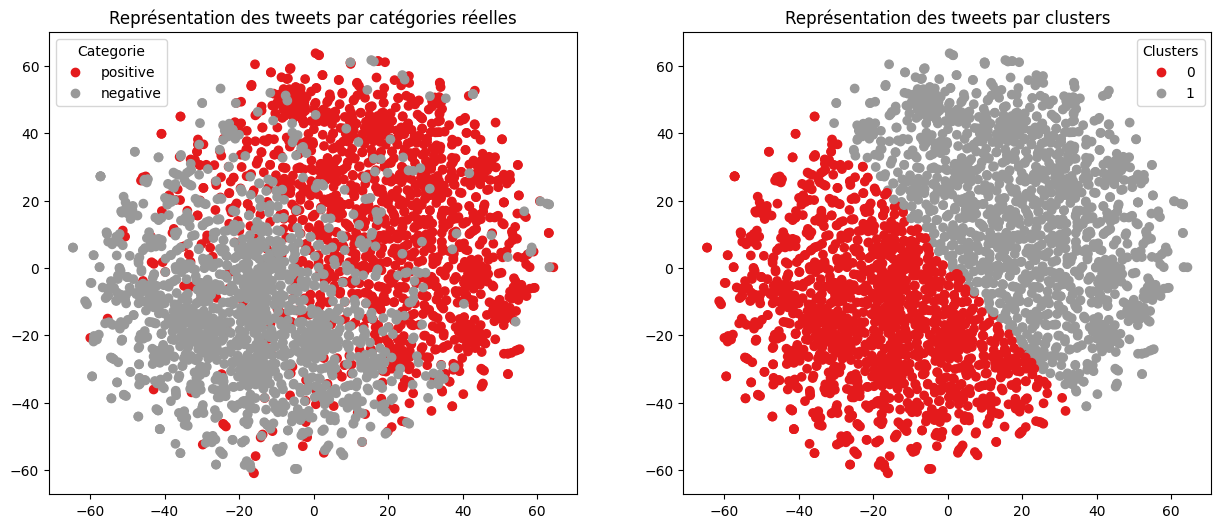

ARI :  0.5182


In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# ➡️➡️ FIN DU CHECKPOINT

De par son fonctionnement, **TF-IDF ne propose pas les tags les plus fréquents**, tels que les noms de langages informatiques ou bibliothèques régulièrement utilisées : c'est là une des limites de cette approche simple.

# <a id='toc4_'></a>[CountVectorizer](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

🚧 Utilisation de CountVectorizer sur les données => LDA l'utilise en entrée

Modèle de comptage vectoriel

In [ ]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)

Entraînement du modèle sur le corpus

In [ ]:
cv_fitted = count_vectorizer.fit(corpus)
cv_names = count_vectorizer.get_feature_names_out()
cv_transformed = cv_fitted.transform(corpus)

Exemple sur un document fictif

🚧 inclure pipeline clean sur doc fictif

In [ ]:
doc = dummy_doc

In [ ]:
# predict
X = cv_fitted.transform([doc])
# display predictions
predictions = results_from_vec_matrix(count_vectorizer, X, n_predictions)

print(f"🔹 Original document:\n    {doc}\n")
print(f"🔹 Predictions:\n    {predictions}\n")

1️⃣- Original document:
    i have a c# issue with overflow memory in library kazakhstanislas causing many problems in my code: how do you manage this? Here is an example: <code>int a = 1; int b = 2; int c = a + b;</code>

2️⃣- Predictions:
    {'int': 2, 'b': 1, 'c': 1, 'c#': 1, 'causing': 1}



# <a id='toc5_'></a>[LDA](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[pyLDAvis for visualization](https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58)

[LDA Gensim 1](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
[LDA Gensim 2](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

Modèle LDA

In [ ]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

# LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

Entraînement et transformation

In [ ]:
lda.fit(cv_transformed)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

Affichage des topics

In [ ]:
n_top_words = 10
topics = get_lda_topics(lda, cv_names, n_top_words)
topics

['model json object field property custom django entity attribute class',
 'windows python command running tried get install version following installed',
 'array data values python list get output column dataframe value',
 'apache remote disable camera profile ssh disabled forms xamarin device',
 'test tests thread testing unit event task call method async',
 'type query key string sql convert name plot format following',
 'data would way want need know one get new help',
 'view problem swift update screen also see change works one',
 'question would one memory different difference used two also seems',
 'table database node view laravel date spark controller npm child',
 'android project studio build visual version app gradle device sdk',
 'app ios xcode react native color rails background apps facebook',
 'function method class object type return call value following variable',
 'time firebase number stream seconds takes times process slow audio',
 '.net framework core set layout it

Exemple sur un document du corpus (biaisé car dans l'entraînement : pour exemple et comparaison des tags seulement)

In [ ]:
n_predictions = 5
doc_index = 13371
doc = corpus[doc_index]

In [ ]:
doc_cv = cv_fitted.transform([doc])
doc_tokens_count = results_from_vec_matrix(count_vectorizer, doc_cv, n_predictions)

print(f"🔹 Original document:\n    {doc}\n")
print(f"🔹 Token count:\n    {doc_tokens_count}\n")

🔹 Original document:
    django sessions working expected heroku users keep getting logged sessions persisting django app heroku users log randomly logged out—even site anything wrong django heroku config currently running django standard dynos settings.py

🔹 Token count:
    {'django': 4, 'heroku': 3, 'logged': 2, 'users': 2, 'sessions': 2}



In [ ]:
# predict topics
topic_preds = lda.transform(doc_cv)[0]
# sort predictions by descending order
n_top_topics = 5
top_topics = topic_preds.argsort()[: -n_top_topics - 1 : -1]
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(f"    Topic {topic} (weight {topic_preds[topic]}):\n        {topics[topic]}")

🔹 Top 5 topics:
    Topic 17 (weight 0.3786462815115825):
        server api user request http client web service application app
    Topic 19 (weight 0.333126503477579):
        project module library angular import get tried folder application trying
    Topic 0 (weight 0.1588245321386544):
        model json object field property custom django entity attribute class
    Topic 6 (weight 0.05851810512542113):
        data would way want need know one get new help
    Topic 13 (weight 0.045884577427807244):
        time firebase number stream seconds takes times process slow audio


# <a id='toc6_'></a>[🚧 gensim LDA ?](#toc0_)

# <a id='toc7_'></a>[🚧 calcul matriciel pour predictions avec LDA](#toc0_)

# <a id='toc8_'></a>[🚧 NMF](#toc0_)

# <a id='toc9_'></a>[🚧 vrac utile](#toc0_)

Création d'un titre fictif pour tests ultérieurs

In [ ]:
dummy_doc = "i have a c# issue with overflow memory in library kazakhstanislas causing many problems in my code: how do you manage this? Here is an example: <code>int a = 1; int b = 2; int c = a + b;</code>"

In [ ]:
stats_df.loc[stats_df.count_title > 10].sort_values(by="count_title", ascending=False)

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
6471,android,7848,0.002476,4762,0.019051,2038,0.006975,5810,0.002019
76811,python,7636,0.002409,7301,0.029209,1916,0.006557,5720,0.001988
7807,app,15812,0.004988,0,0.000000,1423,0.004870,14389,0.005000
90332,spring,4756,0.001500,1579,0.006317,1377,0.004712,3379,0.001174
39069,get,21012,0.006628,34,0.000136,1323,0.004528,19689,0.006842
...,...,...,...,...,...,...,...,...,...
30037,dropout,77,0.000024,3,0.000012,11,0.000038,66,0.000023
75194,producing,121,0.000038,0,0.000000,11,0.000038,110,0.000038
95187,tablet,86,0.000027,8,0.000032,11,0.000038,75,0.000026
40107,glue,55,0.000017,0,0.000000,11,0.000038,44,0.000015
